In [7]:
from IPython.display import display, HTML

display(
    HTML("""
<style>
* {font-family:D2Coding;}
div.container{width:87% !important;}
div.cell.code_cell.rendered{width:100%;}
div.CodeMirror {font-size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input { font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:3px;}
table.dataframe{font-size:12px;}
</style>
"""))

In [ ]:
# import
import numpy as np
import seaborn as sns # iris 데이터
import pandas as pd # 원핫 인코팅
from sklearn.preprocessing import LabelEncoder # 라벨인코딩(문자 → 숫자)
from tensorflow.keras.utils import to_categorical # 원핫인코딩
from sklearn.model_selection import train_test_split # 데이터 분할(층화추출로)
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt # 학습과정 시각화




- iris 데이터
- sepal_length : 꽃받침길이
- sepal_width : 꽃잎넓이
- petal_length : 꽃잎길이
- species : 종 

In [30]:
# 문자변수의 원홧인코딩 방법 1
iris = sns.load_dataset('iris')
# to_categorical(iris['species']) # to_categorical는 정수형으로...
labelEncoder = LabelEncoder()

# labelEncoder.fit(iris['species'])
# iris['y'] = labelEncoder.transform(iris['species'])

iris['y'] = labelEncoder.fit_transform(iris.species)
# iris.iloc[::25]
to_categorical(iris['y'])[::25] # to_categorical의 결과는 numpy배열

# iris


array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [32]:
# 문자변수 원핫인코딩 방법 2
iris = sns.load_dataset('iris')
# iris.head(5)
pd.get_dummies(iris.species).values # pd.get_dummies 결과는 데이터 프레임
pd.get_dummies(iris.species).to_numpy()[::25] # pd.get_dummies 결과는 데이터 프레임

array([[1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1]], dtype=uint8)

In [60]:
# 1. 데이터 생성 및 전처리
iris = sns.load_dataset('iris')
# iris.info() # 결측치 있으면 결측치 처리
# iris['species'].value_counts() # 타켓변수의 분포

# 독립변수와 타켓변수 분리
iris_X = iris.iloc[:,:-1].to_numpy()
# iris_X[:2]
iris_y = iris.iloc[:, -1]
iris_Y = pd.get_dummies(iris_y).values # 원핫인코딩 (넘파이배열)
# iris_Y[::50]

# 훈련셋 : 테스트셋 - 8:2
X_train, X_test, Y_train, Y_test = train_test_split(iris_X, iris_Y, 
                                                    train_size=0.8, # 훈련셋 비율
                                                    # test_size=0.2, # 테스트 비율
                                                    stratify=iris_Y, # 층화추출
                                                    random_state=7 # 랜덤시드값
                                                    )


print(iris_X.shape, iris_Y.shape)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(150, 4) (150, 3)
(120, 4) (30, 4) (120, 3) (30, 3)


In [64]:
# 층화 추출이 되었는지 확인
# iris_Y.argmax(axis=1)
pd.Series(np.argmax(iris_Y, axis=1)).value_counts()

0    50
1    50
2    50
dtype: int64

In [63]:
print(pd.Series(np.argmax(iris_Y, axis=1)).value_counts())
print(pd.Series(np.argmax(Y_train, axis=1)).value_counts())
print(pd.Series(np.argmax(Y_test, axis=1)).value_counts())

0    50
1    50
2    50
dtype: int64
0    40
2    40
1    40
dtype: int64
0    10
2    10
1    10
dtype: int64


In [75]:
# 2. 모델구성 (입력4, 출력3)
model = Sequential()

model.add(Dense(units=64, input_dim=4, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=50, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=30, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(units=3, activation='softmax')) # 출력층

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 64)                320       
                                                                 
 dense_11 (Dense)            (None, 128)               8320      
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_12 (Dense)            (None, 50)                6450      
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_13 (Dense)            (None, 30)                1530      
                                                                 
 dropout_6 (Dropout)         (None, 30)               

In [119]:
# 3. 학습과정 설정
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 4. 학습 : epoch마다 val_accuracy값이 좋아지고 있으면 model 자동 저장 (콜백주기)
    # 모델 자동 저장 경로 : ./model_iris/iris-epo002-val0.8765.h5
import os

model_save_folder = './model_iris/'
if not os.path.exists(model_save_folder): # 폴더가 없으면 폴더생성
    os.mkdir(model_save_folder)

file = model_save_folder + "iris-epo{epoch:03d}-val{val_accuracy:.4f}.h5"

# 모델 자동 저장할 콜백 객체
checkpoint = ModelCheckpoint(filepath=file, 
                             monitor='val_accuracy', # 모니터링 지표 (기본값 : val_loss)
                             model='max',
                             save_best_only=True, # False : 매번 저장
                             verbose=1, # 모델 저장시 로그 출력 (0:로그출력안함)
                             
                             )
# 조기 종료 콜백 객체
earlyStopping = EarlyStopping(patience=40) # monitor 기본값은 val_loss

hist = model.fit(X_train, Y_train,
                 # batch_size=40,
                 epochs=500,
                 validation_split=0.2, # 훈련셋의 20%를 검증셋
                 callbacks=[earlyStopping,checkpoint]
                 )


Epoch 1/500
1/3 [=========>....................] - ETA: 1s - loss: 0.0804 - accuracy: 0.9688
Epoch 1: val_accuracy improved from -inf to 0.95833, saving model to ./model_iris/iris-epo001-val0.9583.h5
3/3 [==============================] - 1s 182ms/step - loss: 0.0535 - accuracy: 0.9896 - val_loss: 0.2151 - val_accuracy: 0.9583
Epoch 2/500
1/3 [=========>....................] - ETA: 0s - loss: 0.1316 - accuracy: 0.9375
Epoch 2: val_accuracy did not improve from 0.95833
3/3 [==============================] - 0s 24ms/step - loss: 0.0853 - accuracy: 0.9479 - val_loss: 0.2709 - val_accuracy: 0.9167
Epoch 3/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0166 - accuracy: 1.0000
Epoch 3: val_accuracy did not improve from 0.95833
3/3 [==============================] - 0s 22ms/step - loss: 0.0569 - accuracy: 0.9792 - val_loss: 0.2226 - val_accuracy: 0.9583
Epoch 4/500
1/3 [=========>....................] - ETA: 0s - loss: 0.0890 - accuracy: 0.9688
Epoch 4: val_accuracy did not impr

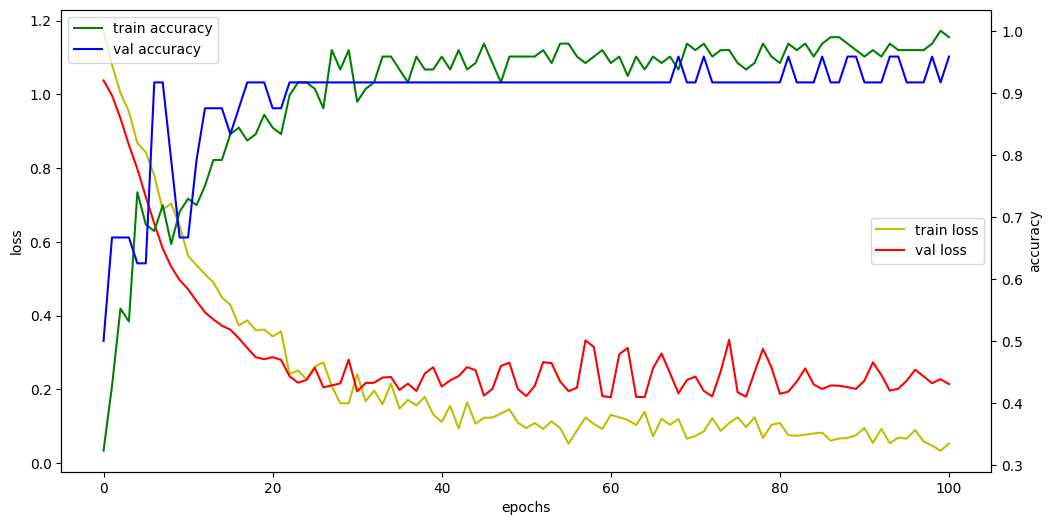

In [77]:
# 5. 모델 학급과정 시각화
fig, loss_ax = plt.subplots(figsize=(12,6))
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'g', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'b', label='val accuracy')
loss_ax.set_xlabel('epochs')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(loc='upper left')
plt.show()

In [105]:
# 6. 학습 완료된 모델의 evaluate:데스트셋, 교차표, recall, precision : y실제값, y예측값
# iris-epo069-val0.9583 모델도 같이 계산
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score

# 학습된 모델
loss, acc = model.evaluate(X_test, Y_test)
loss, acc

# 모델의 recal과 precision을 위해서 실제값과 예측값
# 실재값
# print(Y_test)
real = np.argmax(Y_test, axis=1)

# 예측값
pred = np.argmax(model.predict(X_test), axis=1)

# recall
recall = recall_score(real, pred, average='weighted') # average='weighted' : 다중분류

# precision
precision = precision_score(real, pred, average='weighted')

# f1score
f1 = f1_score(real, pred, average='weighted')

print('model loss :',loss)
print('model accuracy :',acc)
print('model recall :', recall)
print('model precision :', precision)
print('model f1 score :', f1)

# 저장된 모델의 평가
model2 = load_model('model_iris/iris-epo069-val0.9583.h5')
loss2, acc2 = model2.evaluate(X_test, Y_test, verbose=0)

pred2 = model2.predict(X_test, verbose=0).argmax(axis=1)
recall2 = recall_score(real, pred2, average='weighted')
precision2 = precision_score(real, pred2, average='weighted')
f12 = f1_score(real, pred2, average='weighted')

print('model2 loss :',loss2)
print('model2 accuracy :',acc2)
print('model2 recall :', recall2)
print('model2 precision :', precision2)
print('model2 f1 score :', f12)



1/1 [==============================] - 0s 50ms/step - loss: 0.0107 - accuracy: 1.0000


1/1 [==============================] - 0s 55ms/step
model loss : 0.010700186714529991
model accuracy : 1.0
model recall : 1.0
model precision : 1.0
model f1 score : 1.0
model2 loss : 0.03067566268146038
model2 accuracy : 1.0
model2 recall : 1.0
model2 precision : 1.0
model2 f1 score : 1.0


In [107]:
# 교차표
pred = np.argmax(model.predict(X_test), axis=1)
pd.crosstab(real, pred, rownames=['real'], colnames=['pred'])



1/1 [==============================] - 0s 31ms/step


pred,0,1,2
real,,,
0,10,0,0
1,0,10,0
2,0,0,10


In [106]:
confusion_matrix(real, pred)

array([[10,  0,  0],
       [ 0, 10,  0],
       [ 0,  0, 10]])

In [108]:
# 모델 저장 및 사용
save_model(model,'model=iris.h5')
model.save('model/iris.h5') # tensorflow2.18 이상일 경우 확장자를 .keras로도 사용 할 수 있다.

In [118]:
# 모델 예츨하기
iris.iloc[100] # (6.3, 3.3, 6.0, 2.5)
result = model.predict([[6.3, 3.3, 6.0, 2.5]])
np.argmax(result) # virgicolor 로 예측


1/1 [==============================] - 0s 64ms/step


2